<a href="https://colab.research.google.com/github/rkaunismaa/StableDiffusion/blob/main/diffusers/in_painting_with_stable_diffusion_using_diffusers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Monday, February 27, 2023

# In-painting pipeline for Stable Diffusion using 🧨 Diffusers 

This notebook shows how to do text-guided in-painting with Stable Diffusion model using  🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers). 

For a general introduction to the Stable Diffusion model please refer to this [colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb).

In [1]:
!pip install -qq -U diffusers==0.11.1 transformers ftfy gradio accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 KB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 93.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.7/140.7 KB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

To use private and gated models on 🤗 Hugging Face Hub, login is required. If you are only using a public checkpoint (such as `runwayml/stable-diffusion-inpainting` in this notebook), you can skip this step.

In [2]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [3]:
import inspect
from typing import List, Optional, Union

import numpy as np
import torch

import PIL
import gradio as gr
from diffusers import StableDiffusionInpaintPipeline

In [4]:
device = "cuda"
model_path = "runwayml/stable-diffusion-inpainting"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
).to(device)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

In [5]:
import requests
from io import BytesIO

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")

img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

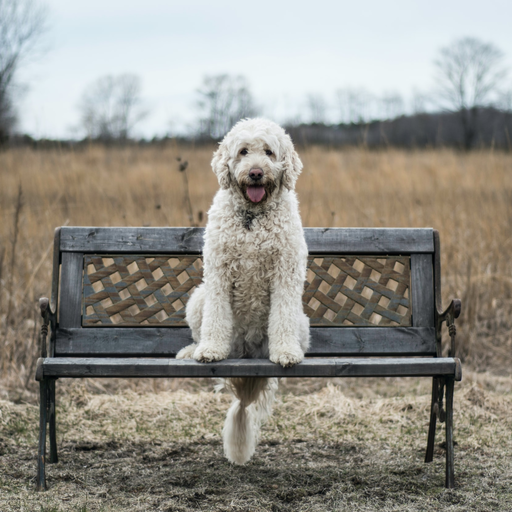

In [6]:
image = download_image(img_url).resize((512, 512))
image

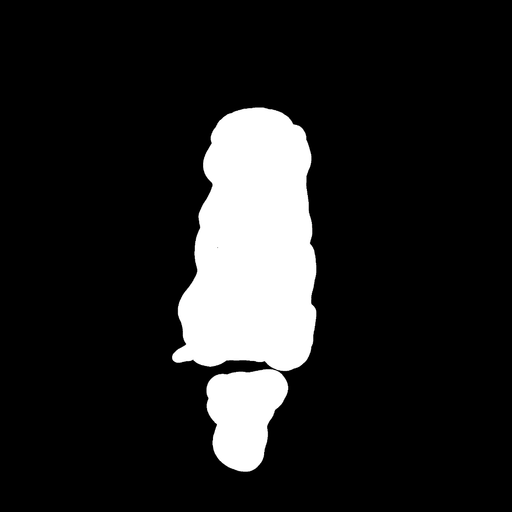

In [7]:
mask_image = download_image(mask_url).resize((512, 512))
mask_image

In [8]:
prompt = "a mecha robot sitting on a bench"

guidance_scale=7.5
num_samples = 3
generator = torch.Generator(device="cuda").manual_seed(0) # change the seed to get different results

images = pipe(
    prompt=prompt,
    image=image,
    mask_image=mask_image,
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

In [9]:
# insert initial image in the list so we can compare side by side
images.insert(0, image)

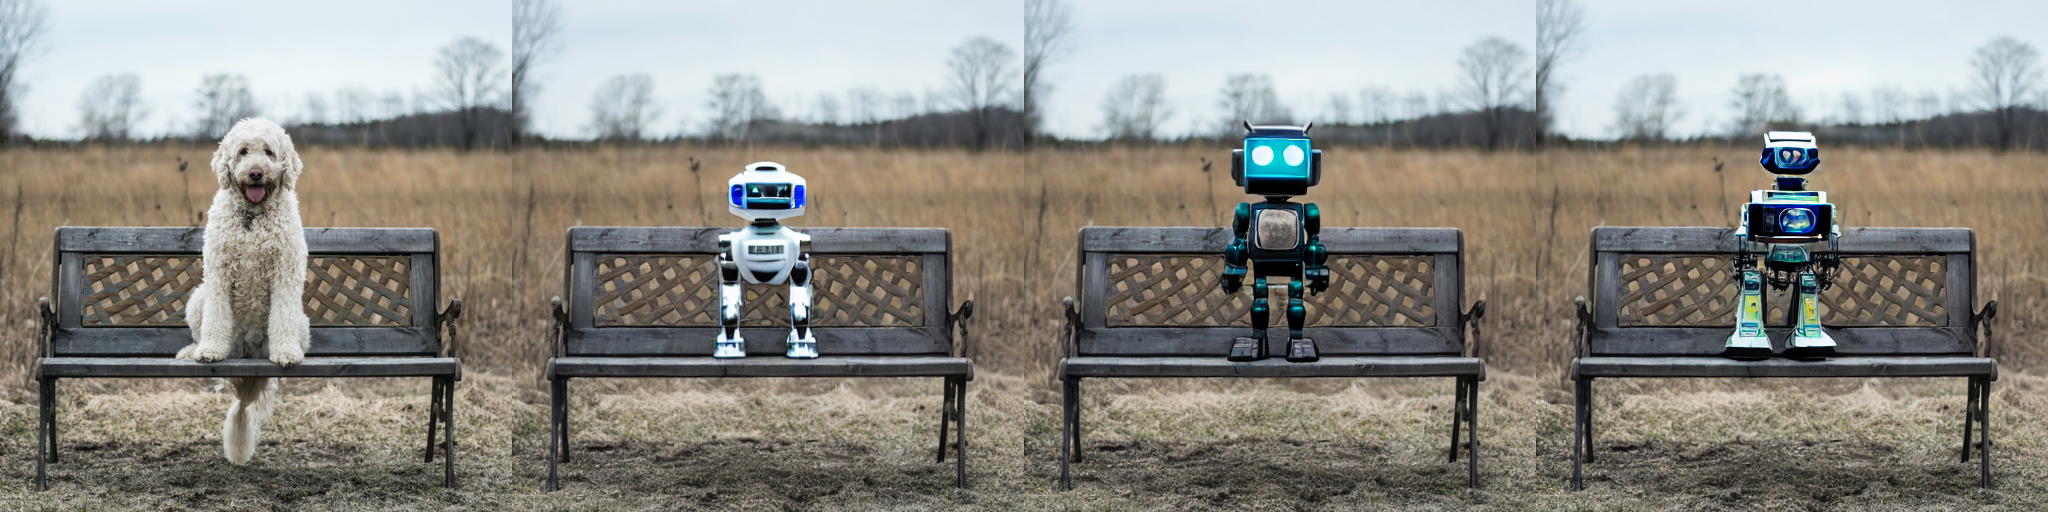

In [10]:
image_grid(images, 1, num_samples + 1)

### Gradio Demo

In [11]:
def predict(dict, prompt):
  image =  dict['image'].convert("RGB").resize((512, 512))
  mask_image = dict['mask'].convert("RGB").resize((512, 512))
  images = pipe(prompt=prompt, image=image, mask_image=mask_image).images
  return(images[0])

In [12]:
gr.Interface(
    predict,
    title = 'Stable Diffusion In-Painting',
    inputs=[
        gr.Image(source = 'upload', tool = 'sketch', type = 'pil'),
        gr.Textbox(label = 'prompt')
    ],
    outputs = [
        gr.Image()
        ]
).launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Keyboard interruption in main thread... closing server.
